# Capstone 2 - Forex Prediction

## Import Libraries

In [3]:
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override() 

import pandas as pd
import json
pd.options.display.float_format = '{:,}'.format
import numpy as np
from scipy import stats
from statsmodels.graphics.gofplots import qqplot
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set()
#matplotlib.rcParams['figure.dpi'] = 300
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from fbprophet import Prophet

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [10]:
# download the past 11 years of historical data
df = pdr.get_data_yahoo('USDZAR=X', start='2010-01-01', interval='1D')
df.drop('Volume', axis=1,inplace=True)
display(df.tail())
display(len(df))

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close
Date,,,,,
2020-11-11,15.595600128173828,15.720100402832031,15.511899948120117,15.589300155639648,15.589300155639648
2020-11-12,15.6048002243042,15.730199813842773,15.524999618530273,15.625699996948242,15.625699996948242
2020-11-13,15.639699935913086,15.679900169372559,15.5246000289917,15.640299797058105,15.640299797058105
2020-11-16,15.499199867248535,15.511500358581543,15.309900283813477,15.501399993896484,15.501399993896484
2020-11-17,15.299300193786621,15.326000213623047,15.297499656677246,15.315369606018066,15.315369606018066


2831

In [11]:
#df_ohlc = df
df = pd.DataFrame(df['Adj Close'])
df.columns = ['USDZAR_Close']
df.head()

,USDZAR_Close
Date,
2010-01-01,7.340199947357178
2010-01-04,7.264900207519531
2010-01-05,7.3018999099731445
2010-01-06,7.302199840545654
2010-01-07,7.424099922180176


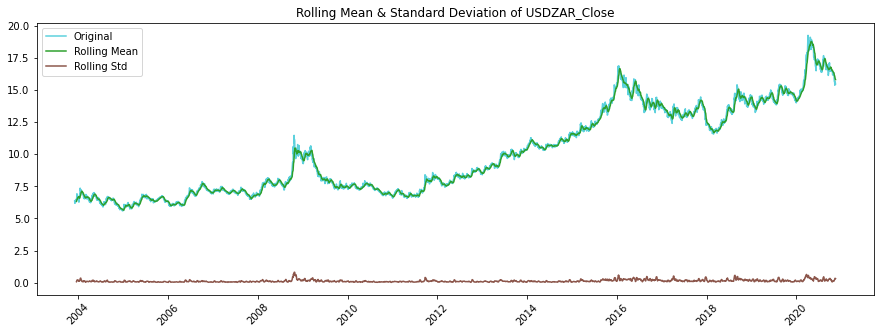

Results of Dickey-Fuller Test:
Test Statistic                -0.7432135962542016
p-value                        0.8352365601966045
# Lags Used                                  20.0
Number of Observations Used               4,390.0
Critical Value (1%)           -3.4318404619161416
Critical Value (5%)            -2.862198602857018
Critical Value (10%)          -2.5671205785565663
dtype: float64


In [598]:
# run adfuller test to determine if time series is stationary
from statsmodels.tsa.stattools import adfuller
def test_stationarity(df, ts):
    """
    Test stationarity using moving average statistics and Dickey-Fuller test
    Source: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
    """
    plt.figure(figsize=(15,5))    
    # Determing rolling statistics
    rolmean = df[ts].rolling(window = 12, center = False).mean()
    rolstd = df[ts].rolling(window = 12, center = False).std()
    
    # Plot rolling statistics:
    orig = plt.plot(df[ts], 
                    color = 'tab:cyan',
                    alpha = 0.7,
                    label = 'Original')
    mean = plt.plot(rolmean, 
                    color = 'tab:green', 
                    label = 'Rolling Mean')
    std = plt.plot(rolstd, 
                   color = 'tab:brown', 
                   label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation of {}'.format(ts))
    plt.xticks(rotation = 45)
    plt.show(block = False)
    plt.close()
    
    # Perform Dickey-Fuller test:
    # Null Hypothesis (H_0): time series is not stationary
    # Alternate Hypothesis (H_1): time series is stationary
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(df[ts], 
                      autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index = ['Test Statistic',
                                  'p-value',
                                  '# Lags Used',
                                  'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(df, 'USDZAR_Close')

## Decomposing Time Series

In [12]:
def plot_decomposition(df, ts, trend, seasonal, residual):
  """
  Plot time series data
  """
  f, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize = (15, 15), sharex = True)

  ax1.plot(df[ts], label = 'Original')
  ax1.legend(loc = 'best')
  ax1.tick_params(axis = 'x', rotation = 45)

  ax2.plot(df[trend], label = 'Trend')
  ax2.legend(loc = 'best')
  ax2.tick_params(axis = 'x', rotation = 45)

  ax3.plot(df[seasonal],label = 'Seasonality')
  ax3.legend(loc = 'best')
  ax3.tick_params(axis = 'x', rotation = 45)

  ax4.plot(df[residual], label = 'Residuals')
  ax4.legend(loc = 'best')
  ax4.tick_params(axis = 'x', rotation = 45)
  plt.tight_layout()

  # Show graph
  plt.suptitle('Trend, Seasonal, and Residual Decomposition of USA/ZAR adjusted close', 
               x = 0.5, 
               y = 1.05, 
               fontsize = 18)
  plt.show()
  plt.close()
  
  return

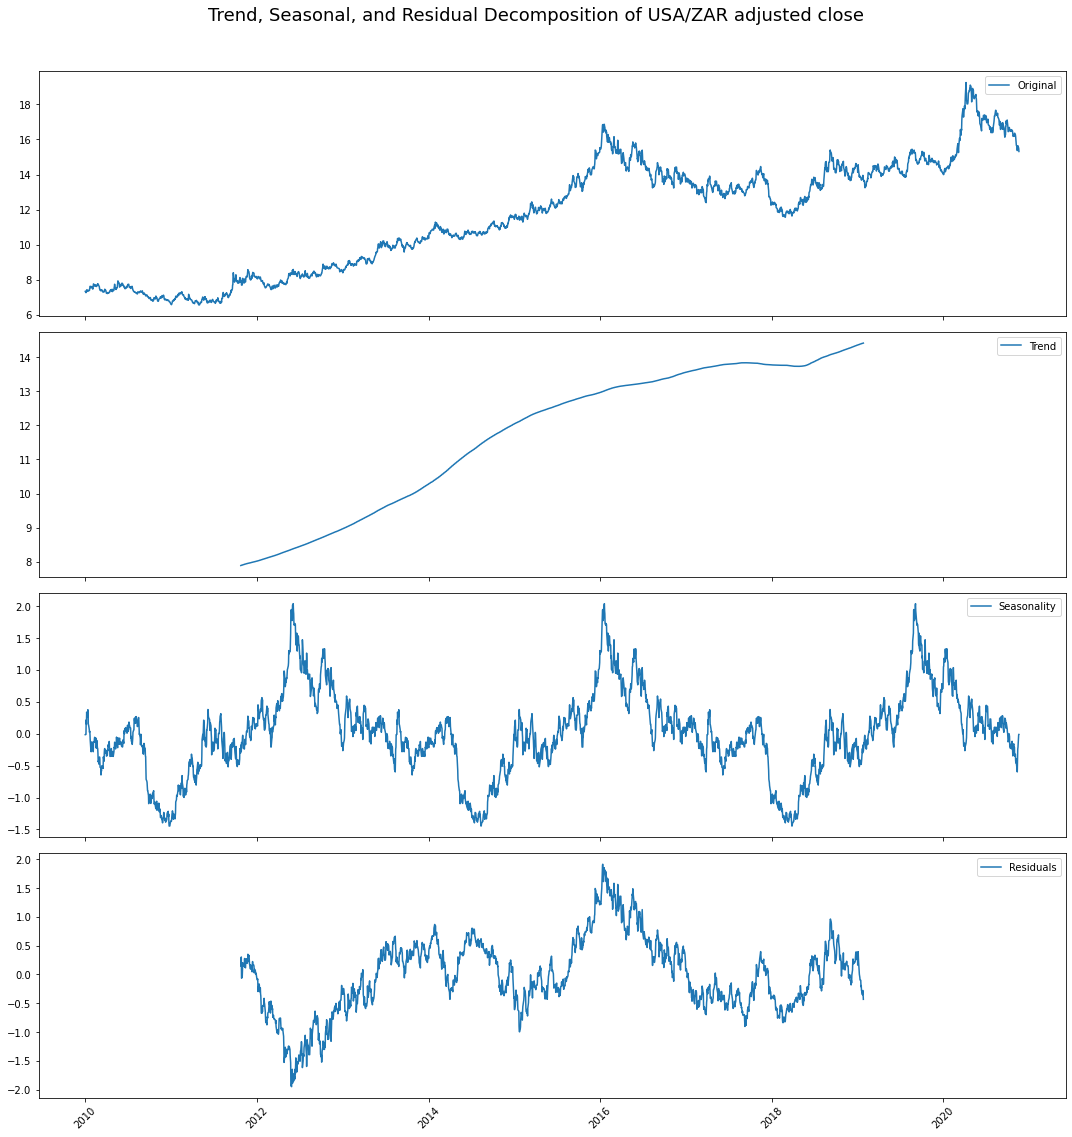

<Figure size 432x288 with 0 Axes>

In [13]:
decomposition = seasonal_decompose(df['USDZAR_Close'], model='additive', period = 943)

df.loc[:,'trend'] = decomposition.trend
df.loc[:,'seasonal'] = decomposition.seasonal
df.loc[:,'residual'] = decomposition.resid

plot_decomposition(df = df, 
                   ts = 'USDZAR_Close', 
                   trend = 'trend',
                   seasonal = 'seasonal', 
                   residual = 'residual')

plt.savefig('decomposed_usdzar.png',dpi=300, bbox_inches='tight')
plt.show()

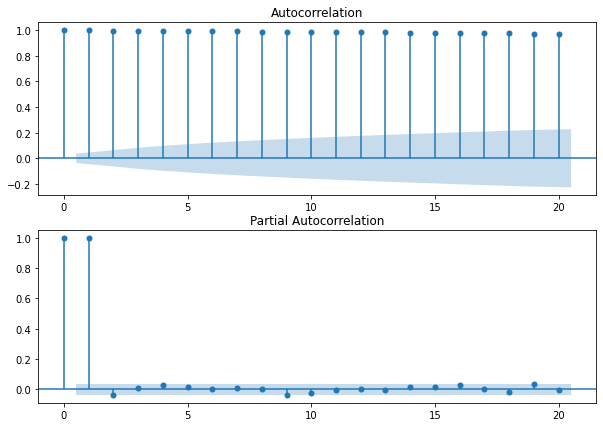

In [15]:
# Plot the ACF and PACF on the same page
fig, axes = plt.subplots(2,1,figsize=(10,7))

# Plot the ACF
plot_acf(df['USDZAR_Close'], lags=20, ax=axes[0])

# Plot the PACF
plot_pacf(df['USDZAR_Close'], lags=20, ax=axes[1])
plt.show()

In [16]:
# Determine best values for p,q,d of the ARIMA model based on lowest AIC
from statsmodels.tsa.arima_model import ARMA, ARIMA
import math
from sklearn.metrics import mean_squared_error

series = df['USDZAR_Close']

# Fit the data to an AR(1) model and print AIC:
mod_ar1 = ARIMA(series, order=(1,0,0))
res_ar1 = mod_ar1.fit()
print("The AIC for an AR(1) is: ", res_ar1.aic)

# Fit the data to an AR(2) model and print AIC:
mod_ar2 = ARIMA(series, order=(1,1,0))
res_ar2 = mod_ar2.fit()
print("The AIC for an AR(1,1) is: ", res_ar2.aic)

# Fit the data to an ARMA(1,1) model and print AIC:
mod_arma3 = ARIMA(series, order=(1,1,1))
res_arma3 = mod_arma3.fit()
print("The AIC for an ARMA(1,1,1) is: ", res_arma3.aic)

# Fit the data to an ARMA(1,1) model and print AIC:
mod_arma4 = ARIMA(series, order=(2,1,1))
res_arma4 = mod_arma4.fit()
print("The AIC for an ARMA(2,1,1) is: ", res_arma4.aic)

The AIC for an AR(1) is:  -3795.874211512276
The AIC for an AR(1,1) is:  -3803.550138909505
The AIC for an ARMA(1,1,1) is:  -3801.869278919944
The AIC for an ARMA(2,1,1) is:  -3802.5935353629184


In [17]:
# Fit the data to an ARMA(20,1) model and print AIC:
mod_ar1 = ARIMA(series, order=(20,1,0))
res_ar1 = mod_ar1.fit()
print("The AIC for an AR(1) is: ", res_ar1.aic)

The AIC for an AR(1) is:  -3805.844515462012


In [18]:
def MAPE(true, pred):
    return 100 * np.mean(np.abs(true - pred) / true)

MAPE for Test Data: 2.7488%


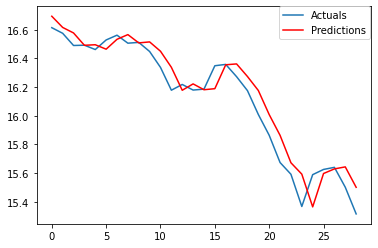

In [19]:
X = series.values
size = int(len(X) * 0.99)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
#    print('predicted=%f, expected=%f' % (yhat, obs))

#errort = MAPE(history, predictions)
#print('Train MAPE for USD/ZAR exchange: %.4f' % errort + str('%'))
errorv = MAPE(test, predictions)
print('MAPE for Test Data: %.4f' % errorv + str('%'))
# plot
plt.plot(test, label='Actuals')
plt.plot(predictions, color='red', label='Predictions')
plt.legend(bbox_to_anchor=(0.725, 1), loc='upper left', borderaxespad=0.)

plt.show()

# Neural Network

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping

dataset = series.values
dataset = dataset.reshape(-1, 1)
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset.shape

(2831, 1)

In [45]:
# split into train and test sets
train_size = int(len(dataset) * 0.99)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

2802 29


In [46]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [47]:
# reshape into X=t and Y=t+1
look_back = 6
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainY[:3]

array([0.06245662, 0.06698931, 0.06346566])

In [48]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

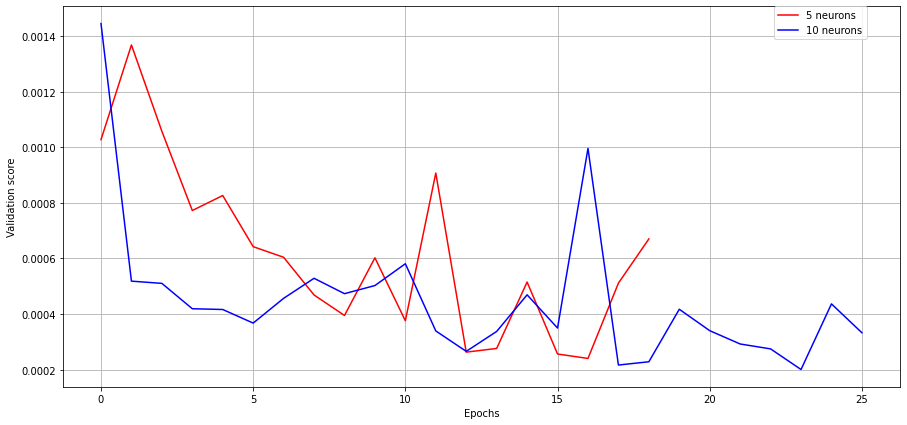

In [49]:
early_stopping_monitor = EarlyStopping(monitor='loss',patience=4)
# create and fit the LSTM network
model_1 = Sequential()
model_1.add(LSTM(5, input_shape=(1, look_back)))
model_1.add(Dense(1))
model_1.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model_1_training = model_1.fit(trainX, trainY, epochs=100, batch_size=1, validation_split=0.2, verbose=False, callbacks=[early_stopping_monitor])

model_2 = Sequential()
model_2.add(LSTM(10, input_shape=(1, look_back)))
model_2.add(Dense(1))
model_2.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model_2_training = model_2.fit(trainX, trainY, epochs=100, batch_size=1, validation_split=0.2, verbose=False, callbacks=[early_stopping_monitor])

# Create the plot
fig, ax = plt.subplots(figsize=(15,7))
plt.plot(model_1_training.history['val_loss'], 'r', label='5 neurons')
plt.plot(model_2_training.history['val_loss'], 'b', label='10 neurons')
plt.xlabel('Epochs')
plt.ylabel('Validation score')
plt.legend(bbox_to_anchor=(0.85, 1), loc='upper left', borderaxespad=0.)
plt.grid()
plt.show()

In [50]:
# make predictions
trainPredict = model_2.predict(trainX)
testPredict = model_2.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

MAPE on Train Data: 0.85%
MAPE on Test Data: 0.83%


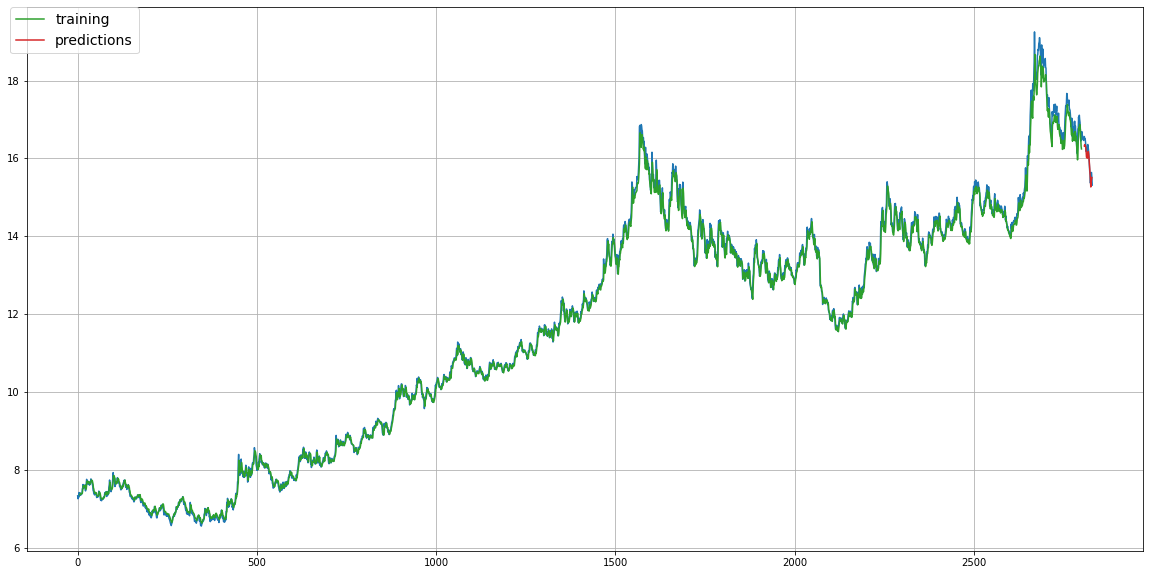

In [51]:
# calculate root mean squared error
trainScore = MAPE(trainY[0], trainPredict[:,0])
print('MAPE on Train Data: %.2f' % (trainScore) + str('%'))
testScore = MAPE(testY[0], testPredict[:,0])
print('MAPE on Test Data: %.2f' % (testScore) + str('%'))

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot, color='tab:green', label='training')
plt.plot(testPredictPlot , color='tab:red', label='predictions')
plt.legend(bbox_to_anchor=(0.1, 1), loc='upper right', borderaxespad=0., fontsize=14)
plt.gcf().set_size_inches(20, 10)
plt.grid()
plt.show()

# Prophet

In [53]:
df['USDZAR_Close'].tail()

Date
2020-11-11   15.589300155639648
2020-11-12   15.625699996948242
2020-11-13   15.640299797058105
2020-11-16   15.501399993896484
2020-11-17   15.315369606018066
Name: USDZAR_Close, dtype: float64

In [54]:
# split into train and test sets
data_p = series.reset_index()
data_p.rename(columns={'Date':'ds','USDZAR_Close':'y'}, inplace=True)
train_size = int(len(data_p) * 0.99)
test_size = len(data_p) - train_size
train_p = data_p.iloc[0:train_size,:]
test_p = data_p.iloc[train_size:,:]
print(len(train_p), len(test_p))
print(train_p.tail())
print(test_p.tail())

2802 29
             ds                  y
2797 2020-10-01  16.73080062866211
2798 2020-10-02 16.448999404907227
2799 2020-10-05 16.458999633789062
2800 2020-10-06  16.54829978942871
2801 2020-10-07  16.68829917907715
             ds                  y
2826 2020-11-11 15.589300155639648
2827 2020-11-12 15.625699996948242
2828 2020-11-13 15.640299797058105
2829 2020-11-16 15.501399993896484
2830 2020-11-17 15.315369606018066


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds               yhat         yhat_lower         yhat_upper
2826 2020-11-01   17.0995404274142 16.386181668620818 17.768595088081856
2827 2020-11-02  17.35626516088202 16.724007471213714  17.99914034792622
2828 2020-11-03  17.36822523148094 16.710678483043285  18.04569927773331
2829 2020-11-04  17.37572375069928  16.72018304335001 18.055823922684958
2830 2020-11-05 17.384460544787018 16.699894676248476 18.081487101071776


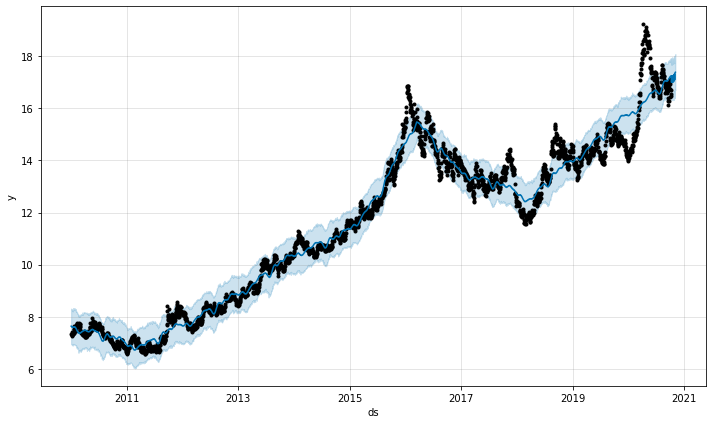

In [55]:
# define the model
model = Prophet()
# fit the model
model.fit(train_p)
# define the period for which we want a prediction
future = model.make_future_dataframe(periods=29)
future.columns = ['ds']
future['ds']= pd.to_datetime(future['ds'])
# use the model to make a forecast
forecast = model.predict(future)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())
# plot forecast
model.plot(forecast)
plt.show()

In [56]:
print('MAPE for Training data: ', round(MAPE(forecast['yhat'].head(2801),train_p['y']),2), str('%'))
print('MAPE for Test data: ', round(MAPE(forecast['yhat'].tail(29),test_p['y']),2), str('%'))

MAPE for Training data:  3.04 %
MAPE for Test data:  6.29 %


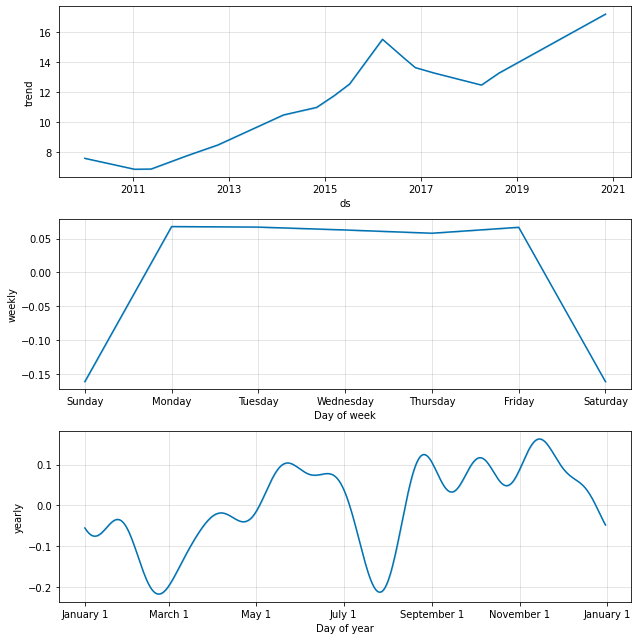

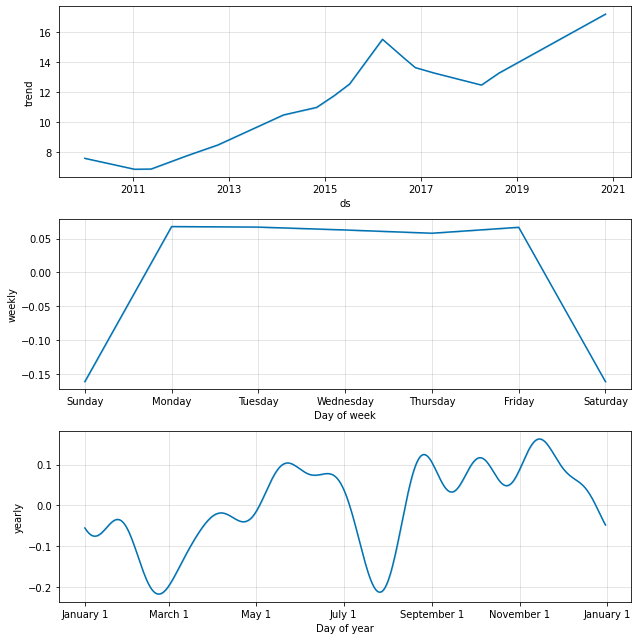

In [647]:
model.plot_components(forecast)